<a href="https://colab.research.google.com/github/Tardiser/Coursera_Capstone/blob/master/istanbulClustered/IstanbulClustered.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <div align="center"> INTRODUCTION </div>
One of the hardest choices for businesses (along with many others) is where to open an office / restaurant / store. This project aims to give businesses some insights by clustering boroughs of Istanbul by using data that includes age, income, and venues nearby. 






*   Let's first import our packages.



In [0]:
import pandas as pd
from geopy.geocoders import Nominatim
import folium
import time
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

* Next, we'll read our csv file that contains average ages for each borough in Istanbul.

In [0]:
istanbul_ages = pd.read_csv("istanbul_age.csv", delimiter = "|")
istanbul_ages.head()

,Unnamed: 0,borough,0-4,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,5-9,60-64,65-69,70-74,75-79,80-84,85-89,90+,Unnamed: 21
0,NaN,İstanbul(Adalar)-1103,576.0,530.0,1020.0,982.0,916.0,1010.0,1082.0,1094.0,1103.0,1067.0,1126.0,596.0,1207.0,939.0,785.0,543.0,346.0,221.0,95.0,NaN
1,NaN,İstanbul(Arnavutköy)-2048,29713.0,25884.0,23049.0,23417.0,25716.0,25575.0,24947.0,19204.0,16207.0,11825.0,10396.0,27618.0,7369.0,4775.0,3033.0,1856.0,1045.0,639.0,220.0,NaN
2,NaN,İstanbul(Ataşehir)-2049,26801.0,28195.0,28641.0,32323.0,33825.0,36355.0,39772.0,37840.0,34329.0,27028.0,22359.0,28411.0,17070.0,12254.0,8799.0,5259.0,3045.0,1962.0,826.0,NaN
3,NaN,İstanbul(Avcılar)-2003,32621.0,31361.0,30865.0,35125.0,38007.0,40610.0,42449.0,37441.0,32593.0,25539.0,22783.0,33354.0,17099.0,12025.0,8032.0,4486.0,2602.0,1398.0,492.0,NaN
4,NaN,İstanbul(Bağcılar)-2004,61874.0,62806.0,61551.0,62757.0,62771.0,64391.0,67838.0,59324.0,54305.0,38932.0,31483.0,62602.0,21130.0,14026.0,9193.0,5191.0,2751.0,1582.0,618.0,NaN


* First and the last columns are empty, let's drop these columns.

In [0]:
# Drop the first and the last columns which are empty.
istanbul_ages.drop([istanbul_ages.columns[0], istanbul_ages.columns[-1]], axis = 1, inplace = True)     
istanbul_ages.head()

,borough,0-4,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,5-9,60-64,65-69,70-74,75-79,80-84,85-89,90+
0,İstanbul(Adalar)-1103,576.0,530.0,1020.0,982.0,916.0,1010.0,1082.0,1094.0,1103.0,1067.0,1126.0,596.0,1207.0,939.0,785.0,543.0,346.0,221.0,95.0
1,İstanbul(Arnavutköy)-2048,29713.0,25884.0,23049.0,23417.0,25716.0,25575.0,24947.0,19204.0,16207.0,11825.0,10396.0,27618.0,7369.0,4775.0,3033.0,1856.0,1045.0,639.0,220.0
2,İstanbul(Ataşehir)-2049,26801.0,28195.0,28641.0,32323.0,33825.0,36355.0,39772.0,37840.0,34329.0,27028.0,22359.0,28411.0,17070.0,12254.0,8799.0,5259.0,3045.0,1962.0,826.0
3,İstanbul(Avcılar)-2003,32621.0,31361.0,30865.0,35125.0,38007.0,40610.0,42449.0,37441.0,32593.0,25539.0,22783.0,33354.0,17099.0,12025.0,8032.0,4486.0,2602.0,1398.0,492.0
4,İstanbul(Bağcılar)-2004,61874.0,62806.0,61551.0,62757.0,62771.0,64391.0,67838.0,59324.0,54305.0,38932.0,31483.0,62602.0,21130.0,14026.0,9193.0,5191.0,2751.0,1582.0,618.0


* We have to manipulate our data a little more, until we get what we want.

In [0]:
istanbul_ages["borough"] = istanbul_ages["borough"].str.split("-", n = 1, expand = True)[0] # Remove "-" and the after part from the borough column.
istanbul_ages["borough"] = istanbul_ages["borough"].str.split("(", n = 1, expand = True)[1] # Remove "İstanbul" before borough names.
istanbul_ages["borough"] = istanbul_ages["borough"].str.split(")", n = 1, expand = True)[0] # Remove the remnant ")" from boroughs.

istanbul_ages[istanbul_ages.columns[1:]] = istanbul_ages[istanbul_ages.columns[1:]].astype('int64') # Convert float columns to int64.
istanbul_ages.head()

,borough,0-4,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,5-9,60-64,65-69,70-74,75-79,80-84,85-89,90+
0,Adalar,576,530,1020,982,916,1010,1082,1094,1103,1067,1126,596,1207,939,785,543,346,221,95
1,Arnavutköy,29713,25884,23049,23417,25716,25575,24947,19204,16207,11825,10396,27618,7369,4775,3033,1856,1045,639,220
2,Ataşehir,26801,28195,28641,32323,33825,36355,39772,37840,34329,27028,22359,28411,17070,12254,8799,5259,3045,1962,826
3,Avcılar,32621,31361,30865,35125,38007,40610,42449,37441,32593,25539,22783,33354,17099,12025,8032,4486,2602,1398,492
4,Bağcılar,61874,62806,61551,62757,62771,64391,67838,59324,54305,38932,31483,62602,21130,14026,9193,5191,2751,1582,618


In [0]:
istanbul_ages["totalPop"] = istanbul_ages.sum(axis = 1) # Total population for each borough.
istanbul_ages.head()

,borough,0-4,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,5-9,60-64,65-69,70-74,75-79,80-84,85-89,90+,totalPop
0,Adalar,576,530,1020,982,916,1010,1082,1094,1103,1067,1126,596,1207,939,785,543,346,221,95,15238
1,Arnavutköy,29713,25884,23049,23417,25716,25575,24947,19204,16207,11825,10396,27618,7369,4775,3033,1856,1045,639,220,282488
2,Ataşehir,26801,28195,28641,32323,33825,36355,39772,37840,34329,27028,22359,28411,17070,12254,8799,5259,3045,1962,826,425094
3,Avcılar,32621,31361,30865,35125,38007,40610,42449,37441,32593,25539,22783,33354,17099,12025,8032,4486,2602,1398,492,448882
4,Bağcılar,61874,62806,61551,62757,62771,64391,67838,59324,54305,38932,31483,62602,21130,14026,9193,5191,2751,1582,618,745125


* Since the ages are divided into groups, we'll use weighted average for calculating the average ages.

In [0]:
weights_index = istanbul_ages.columns[1:-1]
weights = pd.Series([2, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 7, 62, 67, 72, 77, 82, 87, 92], index = weights_index)

# Calculating the weighted average age for each borough.
istanbul_ages["avg_age"] = istanbul_ages[istanbul_ages.columns[1:-1]].dot(weights) / istanbul_ages["totalPop"]
istanbul_ages.head()

,borough,0-4,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,5-9,60-64,65-69,70-74,75-79,80-84,85-89,90+,totalPop,avg_age
0,Adalar,576,530,1020,982,916,1010,1082,1094,1103,1067,1126,596,1207,939,785,543,346,221,95,15238,43.154351
1,Arnavutköy,29713,25884,23049,23417,25716,25575,24947,19204,16207,11825,10396,27618,7369,4775,3033,1856,1045,639,220,282488,28.254372
2,Ataşehir,26801,28195,28641,32323,33825,36355,39772,37840,34329,27028,22359,28411,17070,12254,8799,5259,3045,1962,826,425094,34.425064
3,Avcılar,32621,31361,30865,35125,38007,40610,42449,37441,32593,25539,22783,33354,17099,12025,8032,4486,2602,1398,492,448882,32.903244
4,Bağcılar,61874,62806,61551,62757,62771,64391,67838,59324,54305,38932,31483,62602,21130,14026,9193,5191,2751,1582,618,745125,30.333709


* Now that we've calculated the average ages, we can drop other columns, since we won't need them.

In [0]:
istanbul_ages = istanbul_ages[['borough', 'avg_age']]
istanbul_ages.head()

,borough,avg_age
0,Adalar,43.154351
1,Arnavutköy,28.254372
2,Ataşehir,34.425064
3,Avcılar,32.903244
4,Bağcılar,30.333709


* Next thing we'll do is reading our income file, that contains average income by month and year for each borough.

In [0]:
istanbul_income = pd.read_csv("istanbul_income.csv", delimiter = ";", encoding = "iso8859_9")
istanbul_income.head()

,borough,avg_income_month,avg_income_year
0,Adalar,6.652,79.821
1,Arnavutköy,2.030,24.360
2,Ataşehir,6.577,78.924
3,Avcılar,3.662,43.938
4,Bağcılar,3.197,38.367


* Now, let's combine both dataframe into one.

In [0]:
istanbul_ages = istanbul_ages.merge(istanbul_income.set_index('borough'), on='borough')
istanbul_ages.head()

,borough,avg_age,avg_income_month,avg_income_year
0,Adalar,43.154351,6.652,79.821
1,Arnavutköy,28.254372,2.030,24.360
2,Ataşehir,34.425064,6.577,78.924
3,Avcılar,32.903244,3.662,43.938
4,Bağcılar,30.333709,3.197,38.367


*   We will need center of each borough in Istanbul. Therefore, we'll have to obtain latitudes and longitudes of each one of them. 
*   We will use geopy package to get these coordinates.

In [0]:
lats = []
lons = []
for i in istanbul_ages['borough'].tolist():
    location = i + ', Istanbul, Turkey'
    geolocator = Nominatim(user_agent="to_explorer")
    location = geolocator.geocode(location)
    lats.append(location.latitude)
    lons.append(location.longitude)
    print(i)
    time.sleep(2)

*   Let's add these coordinates to our dataframe with proper column names.


In [0]:
istanbul_ages['Latitude'] = lats
istanbul_ages['Longitude'] = lons



*   We also need the border of these boroughs. To obtain them, we'll read the json file that contains these coordinates.



In [0]:
ist_geo = open("istanbul.json", "r",  encoding="utf8").read()


*   First, we'll start by creating a map centered around Istanbul.


In [0]:
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode('Istanbul, Turkey')
lat = location.latitude
lon = location.longitude

ist_map = folium.Map(location=[lat, lon], zoom_start=10)


*   Next, we'll add the necessary elements to make it a Choropleth map.


In [0]:
folium.Choropleth(
    geo_data=ist_geo,
    data=istanbul_ages,
    columns=['borough', 'avg_age'],
    key_on='feature.properties.name_2',
    fill_color='YlOrRd', 
    fill_opacity=0.9, 
    line_opacity=0.9, 
    nan_fill_color = 'white',
    legend_name='Average age by borough',
    reset = True
).add_to(ist_map)

ist_map



*   We want to get venues around each borough. To obtain these, we'll need Foursquare API. So, let's create our credentials to use Foursquare API.


In [0]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


*   To retrieve the venues for each borough, we'll create a function:



In [0]:
def getNearbyVenues(names, latitudes, longitudes, CLIENT_ID, CLIENT_SECRET, VERSION, radius=1000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



*   And use that function to put it into a dataframe.


In [0]:
istanbul_venues = getNearbyVenues(names=istanbul_ages['borough'],
                                   latitudes=istanbul_ages['Latitude'],
                                   longitudes=istanbul_ages['Longitude'],
                                   CLIENT_ID = CLIENT_ID,
                                   CLIENT_SECRET = CLIENT_SECRET,
                                   VERSION = VERSION
                                  )
istanbul_venues.head()

Adalar
Arnavutköy
Ataşehir
Avcılar
Bağcılar
Bahçelievler
Bakırköy
Başakşehir
Bayrampaşa
Beşiktaş
Beykoz
Beylikdüzü
Beyoğlu
Büyükçekmece
Çatalca
Çekmeköy
Esenler
Esenyurt
Fatih
Gaziosmanpaşa
Güngören
Kadıköy
Kağıthane
Kartal
Küçükçekmece
Maltepe
Pendik
Sancaktepe
Sarıyer
Şile
Şişli
Sultanbeyli
Sultangazi
Tuzla
Ümraniye
Üsküdar
Zeytinburnu


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adalar,40.876259,29.091027,İnönü Evi Müzesi,40.878251,29.093647,History Museum
1,Adalar,40.876259,29.091027,Merit Halki Palace Hotel,40.878802,29.090974,Hotel
2,Adalar,40.876259,29.091027,L'isola Guesthouse,40.877038,29.096136,Bed & Breakfast
3,Adalar,40.876259,29.091027,Luz Café,40.877528,29.097877,Café
4,Adalar,40.876259,29.091027,Heybeliada Şafak Askeri Gazino,40.873609,29.099478,Restaurant




*   Transforming these venues to onehot is useful for us:


In [0]:
# one hot encoding
istanbul_onehot = pd.get_dummies(istanbul_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
istanbul_onehot['Neighborhood'] = istanbul_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [istanbul_onehot.columns[-1]] + list(istanbul_onehot.columns[:-1])
istanbul_onehot = istanbul_onehot[fixed_columns]

istanbul_onehot.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bath House,Bathing Area,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Borek Place,...,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Syrian Restaurant,Taco Place,Tantuni Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Transportation Service,Travel Agency,Tree,Turkish Home Cooking Restaurant,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Store,Volleyball Court,Warehouse Store,Watch Shop,Water Park,Waterfront,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Çöp Şiş Place
0,Adalar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adalar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Adalar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Adalar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Adalar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0




*   Let's see how many venues returned.



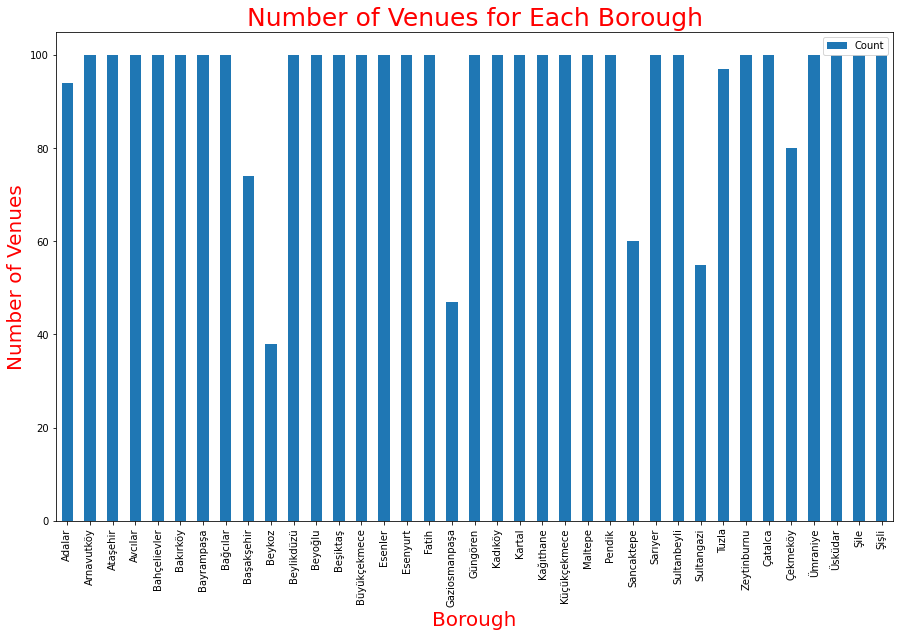

In [0]:
numberofVenues = istanbul_onehot.groupby('Neighborhood').sum().reset_index()
numberofVenues['Count'] = numberofVenues.sum(axis = 1)

numberofVenues.plot(kind = 'bar', x = 'Neighborhood', y = 'Count', figsize = (15,9))
plt.ylabel('Number of Venues', color = 'red', fontsize = 20)
plt.xlabel('Borough', color = 'red', fontsize = 20)
plt.title('Number of Venues for Each Borough', color = 'red', fontsize = 25)

plt.savefig('numberofVenues.png')
plt.show()




*   We don't need to display each venue seperately, let's grouped them by their average.



In [0]:
istanbul_grouped = istanbul_onehot.groupby('Neighborhood').mean().reset_index()
istanbul_grouped.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bath House,Bathing Area,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Borek Place,...,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Syrian Restaurant,Taco Place,Tantuni Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Transportation Service,Travel Agency,Tree,Turkish Home Cooking Restaurant,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Store,Volleyball Court,Warehouse Store,Watch Shop,Water Park,Waterfront,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Çöp Şiş Place
0,Adalar,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.010638,0.00,0.0,0.010638,0.0,0.0,0.042553,0.031915,0.00,0.00,0.0,0.0,0.010638,0.095745,0.021277,0.0,0.00,0.0,0.010638,0.00,0.0,0.031915,0.010638,0.0,...,0.0,0.0,0.010638,0.0,0.0,0.0,0.00,0.0,0.0,0.010638,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.021277,0.0,0.0,0.0,0.0,0.010638,0.00,0.031915,0.010638,0.0,0.00,0.0,0.00,0.0,0.0,0.010638,0.0,0.00,0.00,0.0,0.00
1,Arnavutköy,0.01,0.0,0.0,0.01,0.0,0.0,0.03,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,0.010000,0.010000,0.00,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.01,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.00,0.01,0.01,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.01,0.070000,0.000000,0.0,0.01,0.0,0.01,0.0,0.0,0.000000,0.0,0.01,0.00,0.0,0.00
2,Ataşehir,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.0,0.000000,0.01,0.0,0.000000,0.0,0.0,0.020000,0.000000,0.01,0.02,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.02,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.01,0.0,0.0,0.010000,0.0,0.01,0.01,0.00,0.00,0.0,0.0,0.01,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.010000,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.00,0.01,0.0,0.01
3,Avcılar,0.00,0.0,0.0,0.00,0.0,0.0,0.02,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,0.000000,0.030000,0.00,0.01,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.01,0.0,0.000000,0.010000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.01,0.00,0.00,0.01,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.040000,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.01,0.00,0.0,0.00
4,Bahçelievler,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.010000,0.0,0.0,0.040000,0.000000,0.00,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.01,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.010000,0.0,0.0,0.0,0.0,0.000000,0.01,0.030000,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.00,0.00,0.0,0.00




*   We just wanna have the top 10 venue, or some other number. So, let's create a function for that.



In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]



*   And use it for all boroughs:



In [0]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [0]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = istanbul_grouped['Neighborhood']

for ind in np.arange(istanbul_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(istanbul_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adalar,Café,Beach,Seafood Restaurant,Harbor / Marina,Bakery,Snack Place,Restaurant,Boat or Ferry,Bar,Turkish Restaurant
1,Arnavutköy,Café,Turkish Restaurant,Mobile Phone Shop,Dessert Shop,Fast Food Restaurant,Shoe Store,Restaurant,Arcade,Electronics Store,Steakhouse
2,Ataşehir,Clothing Store,Restaurant,Steakhouse,Gym / Fitness Center,Hotel,Café,Kebab Restaurant,Coffee Shop,Pool,Doner Restaurant
3,Avcılar,Café,Dessert Shop,Gym / Fitness Center,Coffee Shop,Restaurant,Turkish Restaurant,Bar,Gym,Breakfast Spot,Burger Joint
4,Bahçelievler,Café,Dessert Shop,Restaurant,Gym,Bakery,Hookah Bar,Turkish Restaurant,Spa,Pastry Shop,Coffee Shop




*   We want to cluster our data, but before doing that we'll have to modify our dataset.



---





> *  First we'll drop the neighborhood columns from our dataset, since we won't need it during clustering.


> *   Second, we'll scale the columns "avg_age", "avg_income_month" and "avg_income_year" between 0 and 1.

> *   And for the last part, we'll insert these normalized columns into our dataset.













In [0]:
# Drop the neighborhood column.
istanbul_grouped_clustering = istanbul_grouped.drop('Neighborhood', 1)

# Scale the columns between 0 and 1.
avg_age_scaled = (istanbul_ages['avg_age'] - istanbul_ages['avg_age'].min()) / (istanbul_ages['avg_age'].max() - istanbul_ages['avg_age'].min())
avg_income_month = (istanbul_ages['avg_income_month'] - istanbul_ages['avg_income_month'].min()) / (istanbul_ages['avg_income_month'].max() - istanbul_ages['avg_income_month'].min())
avg_income_year = (istanbul_ages['avg_income_year'] - istanbul_ages['avg_income_year'].min()) / (istanbul_ages['avg_income_year'].max() - istanbul_ages['avg_income_year'].min())

# Insert scaled columns into dataset.
istanbul_grouped_clustering.insert(1, 'avg_age', avg_age_scaled)
istanbul_grouped_clustering.insert(2, 'avg_income_month', avg_income_month)
istanbul_grouped_clustering.insert(3, 'avg_income_year', avg_income_year)

istanbul_grouped_clustering.head()

,ATM,avg_age,avg_income_month,avg_income_year,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bath House,Bathing Area,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Trail,Bistro,Boarding House,Boat or Ferry,...,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Syrian Restaurant,Taco Place,Tantuni Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Transportation Service,Travel Agency,Tree,Turkish Home Cooking Restaurant,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Store,Volleyball Court,Warehouse Store,Watch Shop,Water Park,Waterfront,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Çöp Şiş Place
0,0.00,1.000000,0.541852,0.541823,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.010638,0.00,0.0,0.010638,0.0,0.0,0.042553,0.031915,0.00,0.00,0.0,0.0,0.010638,0.095745,0.021277,0.0,0.00,0.0,0.010638,0.00,0.0,0.031915,...,0.0,0.0,0.010638,0.0,0.0,0.0,0.00,0.0,0.0,0.010638,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.021277,0.0,0.0,0.0,0.0,0.010638,0.00,0.031915,0.010638,0.0,0.00,0.0,0.00,0.0,0.0,0.010638,0.0,0.00,0.00,0.0,0.00
1,0.01,0.024451,0.000000,0.000000,0.0,0.0,0.01,0.0,0.0,0.03,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,0.010000,0.010000,0.00,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.01,0.0,0.000000,0.00,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.00,0.01,0.01,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.01,0.070000,0.000000,0.0,0.01,0.0,0.01,0.0,0.0,0.000000,0.0,0.01,0.00,0.0,0.00
2,0.00,0.428466,0.533060,0.533060,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.0,0.000000,0.01,0.0,0.000000,0.0,0.0,0.020000,0.000000,0.01,0.02,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.02,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.01,0.0,0.0,0.010000,0.0,0.01,0.01,0.00,0.00,0.0,0.0,0.01,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.010000,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.00,0.01,0.0,0.01
3,0.00,0.328827,0.191325,0.191266,0.0,0.0,0.00,0.0,0.0,0.02,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,0.000000,0.030000,0.00,0.01,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.01,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.01,0.00,0.00,0.01,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.040000,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.01,0.00,0.0,0.00
4,0.00,0.160591,0.136811,0.136841,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.010000,0.0,0.0,0.040000,0.000000,0.00,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.00,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.01,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.010000,0.0,0.0,0.0,0.0,0.000000,0.01,0.030000,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.00,0.00,0.0,0.00




*   It's important to find the optimal cluster number while using K-means. In order to that, we'll use the elbow method: 



In [0]:
distortions = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state = 0)
    kmeans.fit(istanbul_grouped_clustering)
    distortions.append(kmeans.inertia_)



*   Let's visualize the elbow method.


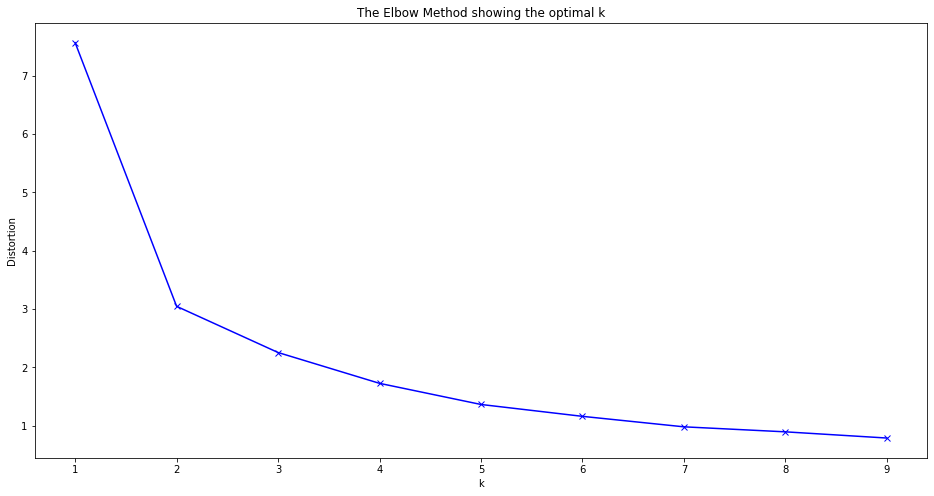

In [0]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.savefig('elbowK.png')
plt.show()



*   Clustering into 5 groups looks reasonable, so let's do that. 


In [0]:
# run k-means clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(istanbul_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 4, 3, 0, 4, 0, 1, 0, 0, 1], dtype=int32)



*   Let's insert our Cluster labels to that merged dataset.


In [0]:
istanbul_merged = istanbul_ages

# add clustering labels
istanbul_merged.insert(0, 'Cluster Labels', kmeans.labels_)



*   And merge all of our findings into one:


In [0]:
istanbul_merged = istanbul_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='borough')

istanbul_merged = istanbul_merged.dropna(subset=['Cluster Labels'])
istanbul_merged['Cluster Labels'] = istanbul_merged['Cluster Labels'].astype(int)
istanbul_merged.head()

,Cluster Labels,borough,avg_age,avg_income_month,avg_income_year,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Adalar,43.154351,6.652,79.821,40.876259,29.091027,Café,Beach,Seafood Restaurant,Harbor / Marina,Bakery,Snack Place,Restaurant,Boat or Ferry,Bar,Turkish Restaurant
1,4,Arnavutköy,28.254372,2.030,24.360,41.184182,28.740729,Café,Turkish Restaurant,Mobile Phone Shop,Dessert Shop,Fast Food Restaurant,Shoe Store,Restaurant,Arcade,Electronics Store,Steakhouse
2,3,Ataşehir,34.425064,6.577,78.924,40.984749,29.106720,Clothing Store,Restaurant,Steakhouse,Gym / Fitness Center,Hotel,Café,Kebab Restaurant,Coffee Shop,Pool,Doner Restaurant
3,0,Avcılar,32.903244,3.662,43.938,40.980135,28.717547,Café,Dessert Shop,Gym / Fitness Center,Coffee Shop,Restaurant,Turkish Restaurant,Bar,Gym,Breakfast Spot,Burger Joint
4,4,Bağcılar,30.333709,3.197,38.367,41.033899,28.857898,Café,Gym,Turkish Restaurant,Dessert Shop,Coffee Shop,Hookah Bar,Pizza Place,Park,Steakhouse,Soup Place




*   We'll a set a color scheme for the clusters.



In [0]:
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

*   Last thing to do is displaying these clusters on our map:

In [0]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(istanbul_merged['Latitude'], istanbul_merged['Longitude'], istanbul_merged['borough'], istanbul_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(ist_map)

In [0]:
ist_map

In [0]:
istanbul_merged.loc[istanbul_merged['Cluster Labels'] == 0, istanbul_merged.columns[list(range(5)) + list(range(7, istanbul_merged.shape[1] - 7))]]

,Cluster Labels,borough,avg_age,avg_income_month,avg_income_year,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
3,0,Avcılar,32.903244,3.662,43.938,Café,Dessert Shop,Gym / Fitness Center
5,0,Bahçelievler,33.491329,4.674,56.088,Café,Dessert Shop,Restaurant
7,0,Başakşehir,29.165150,4.513,54.152,Café,Bakery,Dessert Shop
8,0,Bayrampaşa,34.567620,3.480,41.762,Café,Turkish Restaurant,Hotel
10,0,Beykoz,35.550431,3.693,44.316,Café,Plaza,Park
11,0,Beylikdüzü,33.087647,4.327,51.924,Café,Turkish Restaurant,Restaurant
12,0,Beyoğlu,34.718420,4.773,57.275,Café,Hotel,Art Gallery
13,0,Büyükçekmece,34.238679,3.671,44.049,Café,Coffee Shop,Restaurant
15,0,Çekmeköy,30.951657,3.503,42.033,Café,Turkish Restaurant,Restaurant
19,0,Gaziosmanpaşa,32.582555,3.019,36.228,Café,Turkish Restaurant,Restaurant


In [0]:
istanbul_merged.loc[istanbul_merged['Cluster Labels'] == 1, istanbul_merged.columns[list(range(5)) + list(range(7, istanbul_merged.shape[1] - 7))]]

,Cluster Labels,borough,avg_age,avg_income_month,avg_income_year,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,1,Adalar,43.154351,6.652,79.821,Café,Beach,Seafood Restaurant
6,1,Bakırköy,39.805064,8.845,106.140,Café,Gym,Restaurant
9,1,Beşiktaş,40.721400,10.560,126.720,Café,Coffee Shop,Hotel
21,1,Kadıköy,42.918123,9.025,108.300,Café,Coffee Shop,Art Gallery


In [0]:
istanbul_merged.loc[istanbul_merged['Cluster Labels'] == 2, istanbul_merged.columns[list(range(5)) + list(range(7, istanbul_merged.shape[1] - 7))]]

,Cluster Labels,borough,avg_age,avg_income_month,avg_income_year,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
14,2,Çatalca,37.714208,2.128,25.536,Café,Turkish Restaurant,Restaurant
29,2,Şile,40.729439,2.482,29.789,Beach,Café,Seafood Restaurant


In [0]:
istanbul_merged.loc[istanbul_merged['Cluster Labels'] == 3, istanbul_merged.columns[list(range(5)) + list(range(7, istanbul_merged.shape[1] - 7))]]

,Cluster Labels,borough,avg_age,avg_income_month,avg_income_year,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
2,3,Ataşehir,34.425064,6.577,78.924,Clothing Store,Restaurant,Steakhouse
18,3,Fatih,36.222370,5.281,63.378,Café,Dessert Shop,Kebab Restaurant
25,3,Maltepe,36.186602,5.772,69.259,Café,Turkish Restaurant,Coffee Shop
28,3,Sarıyer,35.755235,7.308,87.696,Café,Seafood Restaurant,Bakery
30,3,Şişli,37.543838,7.822,93.864,Hotel,Coffee Shop,Café
35,3,Üsküdar,36.446491,6.987,83.839,Café,Coffee Shop,Turkish Restaurant


In [0]:
istanbul_merged.loc[istanbul_merged['Cluster Labels'] == 4, istanbul_merged.columns[list(range(5)) + list(range(7, istanbul_merged.shape[1] - 7))]]

,Cluster Labels,borough,avg_age,avg_income_month,avg_income_year,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,4,Arnavutköy,28.254372,2.030,24.360,Café,Turkish Restaurant,Mobile Phone Shop
4,4,Bağcılar,30.333709,3.197,38.367,Café,Gym,Turkish Restaurant
16,4,Esenler,30.565963,2.847,34.164,Café,Restaurant,Turkish Restaurant
17,4,Esenyurt,28.624805,3.024,36.288,Café,Restaurant,Shopping Mall
27,4,Sancaktepe,28.983535,2.633,31.602,Café,Restaurant,Gym
31,4,Sultanbeyli,27.880927,2.172,26.064,Café,Turkish Restaurant,Restaurant
32,4,Sultangazi,29.232844,2.187,26.244,Café,Convenience Store,Men's Store


# <div align="center"> CONCLUSION </div>
In this project, I used the K-Means algorithm to cluster boroughs in Istanbul with features including age, income, and most common venues. These clusters are also marked in a Choropleth map created, for better and easier assessment.

This project is just research. Businesses who want to have insights about where to open an office/restaurant/store, could look into this research and make their own decisions.
